# Aug 28, 2025: visualize marginals
brainrender

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
import random
import re

from sklearn.utils import resample

# import arviz as az

import ants
import nibabel as nib

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial
from multiprocessing import Process

# networks
import graph_tool.all as gt

# 3d rendering
from brainrender import Scene, actor

import pyvista as pv
from vedo import Mesh, settings
settings.default_backend = 'k3d'
from vedo import Volume, show
from skimage.measure import marching_cubes
from scipy.ndimage import label, binary_fill_holes, binary_closing

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from matplotlib.colors import Normalize

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.source ='allen' #'spatial' #'allen'
args.space = 'ccfv2' #'yale' #'ccfv2'
args.brain_div = 'whl' #'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
TEMP_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_res-{args.resolution}'
)
TEMP_DESC

'source-allen_space-ccfv2_res-200'

In [5]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [6]:
parcels_file = f'{PARCELS_path}/{PARC_DESC}_desc-parcels.nii.gz'
parcels_img = nib.load(parcels_file)

try:
    roi_table = pd.read_csv(f'{PARCELS_path}/{PARC_DESC}_desc-names.csv')
    roi_labels = roi_table['roi'].to_numpy()
except:
    roi_labels = np.arange(1, args.num_rois+1)

In [7]:
template_file = f'{PARCELS_path}/{TEMP_DESC}_desc-template.nii.gz'
template_img = nib.load(template_file)

In [8]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['m', 'a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [9]:
def get_membership_matrix(num_rois, df, col='pi'):
    pis = [np.zeros((num_rois, 1)) if np.isnan(pi).all() else pi for pi in df[col]]

    num_modes = len(df)
    num_comms = np.max([pi.shape[-1] for pi in pis])
    num_rois = num_rois
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode, pi in enumerate(pis):
        M[:, idx_mode, :pi.shape[-1]] = pi
    
    return M

In [10]:
marginals_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl', recursive=True))
marginals_df = []
for sbm_file in marginals_files:
    with open(f'{sbm_file}', 'rb') as f:
        row = pickle.load(f)
    marginals_df += [row]
marginals_df = pd.concat(marginals_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in marginals_df['sub'].value_counts().sort_index().to_list()]))
marginals_df['mode_id'] = mode_ids
marginals_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned,omega,mode_id
0,SLC01,sbm-nd-h,"[[0.9887005649717514, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9359379488652687, 0.005585878898145489, 0....","[[0.930047423159928, 0.0689598675440289, 0.000...","[[0.9834189123072902, 0.016581087692710064], [...","[[0.9986182426922744, 0.0013817573077258387], ...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...",0.177295,0
1,SLC01,sbm-nd-h,"[[0.9924242424242424, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9310146923783288, 0.030073461891643713, 0....","[[0.9138235946904278, 0.08582466128530745, 0.0...","[[0.9869962634416201, 0.013003736558379917], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...",0.132086,1
2,SLC01,sbm-nd-h,"[[0.9918032786885246, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9911314162859447, 0.0, 0.0083310937919914,...","[[0.942153748551641, 0.049652834378207875, 0.0...","[[0.9897684668039898, 0.0102315331960104], [0....","[[0.9979536933607981, 0.0020463066392020796], ...","[[1.0000000000000002], [1.0], [1.0], [1.0], [1...","[[1.0000000000000002], [1.0], [1.0], [1.0], [1...","[[1.0000000000000002], [1.0], [1.0], [1.0], [1...","[[1.0000000000000002], [1.0], [1.0], [1.0], [1...",0.122464,2
3,SLC01,sbm-nd-h,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.978494623655914, 0.0, 0.021505376344086023...","[[0.9556018036767258, 0.03341426754538097, 0.0...","[[0.9886639548450163, 0.01133604515498376], [0...","[[0.9981106591408362, 0.0018893408591639602], ...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...",0.093199,3
4,SLC01,sbm-nd-h,"[[0.4782608695652174, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9153526246909989, 0.011887450923367746, 0....","[[0.8920970026110978, 0.09795351233791275, 0.0...","[[0.9745841708956559, 0.025415829104343764], [...","[[0.9999999999999997], [0.9999999999999999], [...","[[0.9999999999999997], [0.9999999999999999], [...","[[0.9999999999999997], [0.9999999999999999], [...","[[0.9999999999999997], [0.9999999999999999], [...","[[0.9999999999999997], [0.9999999999999999], [...",0.091858,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.03, 0.0, 0.965, 0.004775, 0.0, 0.0, 0.0, 0...","[[0.9599766855670102, 0.034953587628865974, 9....","[[0.9916111389690722, 0.008388861030927834], [...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...",0.200220,2
70,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007142857142...","[[0.009285714285714286, 0.0, 0.983673469387755...","[[0.9492891635379744, 0.050709816053862454, 1....","[[0.9895083139198907, 0.010491686080109475], [...","[[1.0000000000000002], [1.0000000000000002], [...","[[1.0000000000000002], [1.0000000000000002], [...","[[1.0000000000000002], [1.0000000000000002], [...","[[1.0000000000000002], [1.0000000000000002], [...","[[1.0000000000000002], [1.0000000000000002], [...",0.140248,3
71,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.1774193548387097, 0.0, 0.8225806451612904,...","[[0.9793400971210545, 0.020659902878945542], [...","[[0.9979340097121056, 0.002065990287894554], [...","[[1.0], [1.0], [1.0000000000000002], [1.0], [0...","[[1.0], [1.0], [1.0000000000000002], [1.0], [0...",

In [11]:
cols = [col for col in  list(marginals_df.columns) if 'pi_' in col]
cols


[
    'pi_0_aligned',
    'pi_1_aligned',
    'pi_2_aligned',
    'pi_3_aligned',
    'pi_4_aligned',
    'pi_5_aligned',
    'pi_6_aligned',
    'pi_7_aligned',
    'pi_8_aligned'
]

In [12]:
# SOFT MARGINALS
soft_marginals_df = []
for sub, group in marginals_df.groupby('sub'):
    omegas = group['omega'].to_list()
    dct = {'sub': [sub], 'sbm': [SBM]}
    for col in cols:
        M = get_membership_matrix(args.num_rois, group, col=col)
        SCs = np.average(M, axis=1, weights=omegas) # soft-comms.
        SCs = np.round(SCs, decimals=3)
        dct[col] = [SCs]
    soft_marginals_df += [pd.DataFrame(dct)]
soft_marginals_df = pd.concat(soft_marginals_df).reset_index(drop=True)
soft_marginals_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,SLC01,sbm-nd-h,"[[0.875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.943, 0.008, 0.031, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.928, 0.065, 0.005, 0.0, 0.001, 0.001], [0....","[[0.987, 0.013], [0.979, 0.021], [0.98, 0.02],...","[[0.999, 0.001], [0.997, 0.003], [0.998, 0.002...","[[1.0, 0.0], [0.999, 0.001], [0.999, 0.001], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
1,SLC03,sbm-nd-h,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.323, 0.0, 0.014, 0.0, 0.0, 0.0, 0.0, 0.663...","[[0.583, 0.361, 0.021, 0.0, 0.006, 0.0, 0.0, 0...","[[0.948, 0.051, 0.0, 0.0, 0.001], [0.966, 0.03...","[[0.99, 0.01], [0.994, 0.006], [0.993, 0.007],...","[[0.999, 0.001], [0.999, 0.001], [0.999, 0.001...","[[0.999, 0.0, 0.001], [1.0, 0.0, 0.0], [1.0, 0...","[[0.999, 0.0, 0.001], [1.0, 0.0, 0.0], [1.0, 0...","[[0.999, 0.001], [1.0, 0.0], [1.0, 0.0], [1.0,..."
2,SLC04,sbm-nd-h,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.019, 0.193, 0.08, 0.0, 0.0, 0.0, 0.0, 0.00...","[[0.851, 0.127, 0.018, 0.005, 0.0, 0.0, 0.0, 0...","[[0.98, 0.02, 0.0], [0.979, 0.021, 0.0], [0.98...","[[0.997, 0.003], [0.997, 0.003], [0.998, 0.002...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
3,SLC05,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.01, 0.96, 0.0, 0.0, 0.0, 0.0, 0.0, 0.027, ...","[[0.892, 0.102, 0.006, 0.0, 0.0, 0.0], [0.893,...","[[0.98, 0.02], [0.98, 0.02], [0.98, 0.02], [0....","[[0.995, 0.005], [0.995, 0.005], [0.995, 0.005...","[[0.999, 0.001], [0.999, 0.001], [0.999, 0.001...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
4,SLC06,sbm-nd-h,"[[0.014, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.992, 0.0, 0.0, 0.0, 0.008, 0.0, 0.0, 0.0, ...","[[0.912, 0.071, 0.015, 0.0, 0.002, 0.0, 0.0, 0...","[[0.985, 0.015], [0.967, 0.033], [0.967, 0.033...","[[0.998, 0.002], [0.993, 0.007], [0.994, 0.006...","[[0.999, 0.001], [0.998, 0.002], [0.998, 0.002...","[[1.0, 0.0, 0.0], [0.999, 0.0, 0.001], [0.999,...","[[1.0, 0.0, 0.0], [0.999, 0.0, 0.001], [0.999,...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
5,SLC07,sbm-nd-h,"[[0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.006, 0.989, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005...","[[0.875, 0.122, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.981, 0.019], [0.981, 0.019], [0.981, 0.019...","[[0.995, 0.005], [0.995, 0.005], [0.995, 0.005...","[[0.999, 0.001], [0.999, 0.001], [0.999, 0.001...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
6,SLC08,sbm-nd-h,"[[0.008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.062, 0.844, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001...","[[0.879, 0.096, 0.023, 0.001, 0.0, 0.0, 0.0, 0...","[[0.981, 0.018, 0.001], [0.981, 0.018, 0.001],...","[[0.996, 0.004], [0.996, 0.004], [0.996, 0.004...","[[0.999, 0.001], [0.999, 0.001], [0.999, 0.001...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
7,SLC09,sbm-nd-h,"[[0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.865, 0.0, 0.06, 0.043, 0.004, 0.025, 0.003...","[[0.934, 0.05, 0.011, 0.001, 0.005, 0.0, 0.0, ...","[[0.992, 0.008, 0.0], [0.971, 0.029, 0.0], [0....","[[0.998, 0.002], [0.995, 0.005], [0.995, 0.005...","[[1.0, 0.0], [0.999, 0.001], [0.999, 0.001], [...","[[1.0, 0.0, 0.0], [0.999, 0.0, 0.001], [0.999,...","[[1.0, 0.0, 0.0], [0.999, 0.0, 0.001], [0.999,...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1

In [13]:
def bootstrap(matrices, statistic=np.median, n_bootstrap=1000):
    stacked = np.stack(matrices)
    bootstrap_means = np.stack([
        statistic(resample(stacked), axis=0)
        for _ in range(n_bootstrap)
    ])
    return (
        statistic(bootstrap_means, axis=0), # mean := probability of var type per roi
        np.percentile(bootstrap_means, [2.5, 97.5], axis=0) # CI
    )

In [14]:
# group-level aggregates
group_marginals_df = []
for col in cols:
    M = get_membership_matrix(args.num_rois, soft_marginals_df, col=col)
    m, ci = bootstrap(
        [M[:, i, :] for i in range(M.shape[1])],
        n_bootstrap=100,
    )
    row = pd.DataFrame(dict(
        sbm=[SBM],
        col=[col],
        vals=[np.squeeze(M)],
        mean=[m],
        cil=[ci[0]],
        ciu=[ci[1]],
    ))
    group_marginals_df += [row]
group_marginals_df = pd.concat(group_marginals_df).reset_index(drop=True)
group_marginals_df

,sbm,col,vals,mean,cil,ciu
0,sbm-nd-h,pi_0_aligned,"[[[0.875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[[0.008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.9406249999999989, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,sbm-nd-h,pi_1_aligned,"[[[0.943, 0.008, 0.031, 0.0, 0.0, 0.0, 0.0, 0....","[[0.062, 0.008, 0.014, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.019, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00047...","[[0.865, 0.844, 0.07049999999999983, 0.001, 0...."
2,sbm-nd-h,pi_2_aligned,"[[[0.928, 0.065, 0.005, 0.0, 0.001, 0.001, 0.0...","[[0.892, 0.096, 0.011, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.851, 0.065, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.928, 0.127, 0.018, 0.002, 0.005, 0.0, 0.0,..."
3,sbm-nd-h,pi_3_aligned,"[[[0.987, 0.013, 0.0, 0.0, 0.0], [0.948, 0.051...","[[0.981, 0.018, 0.0, 0.0, 0.0], [0.979, 0.021,...","[[0.98, 0.011949999999999999, 0.0, 0.0, 0.0], ...","[[0.98805, 0.02, 0.0, 0.0, 0.0], [0.981, 0.031..."
4,sbm-nd-h,pi_4_aligned,"[[[0.999, 0.001], [0.99, 0.01], [0.997, 0.003]...","[[0.997, 0.003], [0.995, 0.005], [0.995, 0.005...","[[0.995, 0.002], [0.994, 0.0034750000000000002...","[[0.998, 0.005], [0.996525, 0.006], [0.99705, ..."
5,sbm-nd-h,pi_5_aligned,"[[[1.0, 0.0], [0.999, 0.001], [1.0, 0.0], [0.9...","[[0.999, 0.001], [0.999, 0.001], [0.999, 0.001...","[[0.999, 0.0], [0.999, 0.0], [0.999, 0.0], [0....","[[1.0, 0.001], [1.0, 0.001], [1.0, 0.001], [1...."
6,sbm-nd-h,pi_6_aligned,"[[[1.0, 0.0, 0.0], [0.999, 0.0, 0.001], [1.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
7,sbm-nd-h,pi_7_aligned,"[[[1.0, 0.0, 0.0], [0.999, 0.0, 0.001], [1.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [0.999475, 0.0, 0.0], [0.999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.000524999999999..."
8,sbm-nd-h,pi_8_aligned,"[[[1.0, 0.0], [0.999, 0.001], [1.0, 0.0], [1.0...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0..."


In [15]:
# if SBM == 'sbm-nd-h':
#     X = group_marginals_df.at[1, 'mean']
#     X[:, 5] += X[:, 6]
#     group_marginals_df.at[1, 'mean'] = X

In [16]:
def taubin_smooth_vedo_mesh(mesh: Mesh, n_iter=50, pass_band=0.5) -> Mesh:
    vtk_poly = mesh.dataset
    pv_mesh = pv.wrap(vtk_poly)
    smoothed = pv_mesh.smooth_taubin(n_iter=n_iter, pass_band=pass_band)
    return Mesh(smoothed)

def create_mesh_from_volume(
        volume: np.ndarray,
        threshold: float = 75,
        spacing: tuple = (200, 200, 200),
        origin: tuple = (0, 0, 0),
        smoothing: dict = {'n_iter': 50, 'pass_band': 0.5},
        color: str = 'cornflowerblue',
        alpha: float = 1.0,
) -> Mesh:
    threshold = np.percentile(volume, threshold)
    verts, faces, *_ = marching_cubes(volume.astype(np.uint8), level=threshold)

    verts = np.asarray(spacing) * verts + np.asarray(origin)
    faces = faces.astype(np.uint32)
    faces_vtk = np.c_[np.full(len(faces), 3), faces].flatten()

    mesh = Mesh([verts, faces_vtk])
    mesh = taubin_smooth_vedo_mesh(mesh, **smoothing)
    mesh.color(color).alpha(alpha)
    return mesh

In [17]:
def create_brain_surface(
    template_img: nib.Nifti1Image,
    threshold: float = 75,
    resolution: int = 200,
    smoothing: dict = {'n_iter': 100, 'pass_band': 0.5},
    color: str = '#cccccc',
    alpha: float = 0.1,
) -> Mesh:
    # Load and reorient
    volume = template_img.get_fdata()
    volume = np.transpose(volume, (2, 1, 0))[::-1, :, :]
    
    # Threshold
    tval = np.percentile(volume, threshold)
    mask = (volume >= tval).astype(np.uint8)
    mask = binary_fill_holes(mask)
    mask = binary_closing(mask, structure=np.ones((2, 2, 2)))

    # Marching cubes on thresholded mask
    verts, faces, *_ = marching_cubes(mask, level=0.5)
    spacing = np.array([resolution] * 3)
    origin = np.array([0] * 3)
    verts = spacing * verts + origin
    faces = faces.astype(np.uint32)
    faces_vtk = np.c_[np.full(len(faces), 3), faces].flatten()

    # Create mesh
    mesh = Mesh([verts, faces_vtk])

    # Split into connected pieces, keep largest
    mesh_pieces = mesh.split(maxdepth=1, sort_by_area=True)
    largest = max(mesh_pieces, key=lambda m: m.npoints)

    # Smooth and color
    largest = taubin_smooth_vedo_mesh(largest, **smoothing)
    largest.color(color).alpha(alpha)

    return largest
    return template_mesh

def render_roi_vector_on_brain(
        scene: Scene,
        parcels_img: nib.Nifti1Image,
        roi_vector: np.ndarray,
        roi_labels: list,
        threshold: float = 75,
        color: str = 'cornflowerblue',
        alpha_threshold: float = 0.1,
        resolution: int = 200,
        smoothing: dict = {'n_iter': 50, 'pass_band': 0.5},
):
    assert len(roi_vector) == len(roi_labels), "Mismatch between marginals and labels"

    data = np.round(parcels_img.get_fdata()).astype(int)
    data = np.transpose(data, (2, 1, 0))[::-1, :, :]
    spacing = np.array([resolution] * 3)
    origin = np.array([0]*3)

    for roi_label, membership in tqdm(zip(roi_labels, roi_vector)):
        if membership < alpha_threshold:
            continue

        mask = (data == roi_label).astype(np.uint8)
        if not np.any(mask):
            continue

        
        norm = Normalize(vmin=0, vmax=1)
        cmap = cc.cm.CET_L12
        color_rgb = cmap(norm(membership))[:3]
        hex_color = '#%02x%02x%02x' % tuple(int(255 * c) for c in color_rgb)
        
        mesh = create_mesh_from_volume(
            mask, 
            threshold, 
            spacing, origin, 
            smoothing, 
            color=hex_color, 
            alpha=1.0, 
        )

        scene.add(actor.Actor(mesh, br_class='Volume'))

    return scene


In [18]:
args.threshold = 75
template_mesh = create_brain_surface(
    template_img=template_img,
    threshold=args.threshold,
    resolution=args.resolution,
    smoothing=dict(n_iter=100, pass_band=0.2),
)
template_mesh_file = f'{PARCELS_path}/{TEMP_DESC}_desc-template-{args.threshold}.vtk'
_ = template_mesh.write(template_mesh_file)

In [19]:
def render_single_comm(
    args, 
    row_dict,  # we convert row to dict to make it pickle-safe
    idx_comm, 
    mode_id, 
    template_mesh, 
    parcels_img, 
    roi_labels, 
    folder=None
):
    if isinstance(mode_id, int):
        mode_str = f'{mode_id:02d}'
    else:
        mode_str = str(mode_id)

    level = row_dict['col'].replace('pi_', '').replace('_aligned', '')
    pi = np.array(row_dict['mean'])
    roi_vector = pi[:, idx_comm]
    alpha_threshold = 0.05 if level == '1' else 0.2

    if folder is None:
        folder = (
            f'{ESTIM_path}/group/membership-mats-group-aligned'
            f'/{SBM}/marginal-visuals/res-{args.resolution}/3d'
        )
    os.makedirs(folder, exist_ok=True)

    scene = Scene(atlas_name='allen_mouse_100um')
    scene.root.alpha(0.0)
    scene.add(actor.Actor(template_mesh, br_class='Volume'))

    scene = render_roi_vector_on_brain(
        scene=scene,
        parcels_img=parcels_img,
        roi_vector=roi_vector,
        roi_labels=roi_labels,
        threshold=75,
        color='cornflowerblue',
        alpha_threshold=alpha_threshold,
        resolution=args.resolution,
        smoothing=dict(n_iter=100, pass_band=0.2),
    )

    fname = f'{folder}/mode-{mode_str}_level-{level}_comm-{idx_comm}.html'
    scene.export(fname)

    return

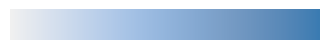

In [20]:
cmap = cc.cm.CET_L12
gradient = np.linspace(0, 1, 256).reshape(1, -1)
fig, ax = plt.subplots(figsize=(4, 0.4))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()
plt.tight_layout()

folder = (
    f'{ESTIM_path}/group/membership-mats-group-aligned'
    f'/{SBM}/marginal-visuals/res-{args.resolution}/3d'
)
fig.savefig(f'{folder}/colormap_CET_L12.svg', bbox_inches='tight', transparent=True)

In [21]:
mode_id = 'x'
folder = (
    f'{ESTIM_path}/group/membership-mats-group-aligned'
    f'/{SBM}/marginal-visuals/res-{args.resolution}/3d'
)
os.makedirs(folder, exist_ok=True)

processes = []

for _, row in group_marginals_df.iterrows():
    pi = np.array(row['mean'])
    row_dict = dict(col=row['col'], mean=pi)  # safe form
    for idx_comm in range(pi.shape[1]):  # communities are columns
        render_single_comm(
            args,
            row_dict,
            idx_comm,
            mode_id,
            template_mesh,
            parcels_img,
            roi_labels,
            folder,
        )

172it [00:00, 3597.10it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-0.html

172it [00:00, 2033.34it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-1.html

172it [00:00, 11574.21it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-2.html

172it [00:00, 4466.97it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-3.html

172it [00:00, 4009.34it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-4.html

172it [00:00, 3152.56it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-5.html

172it [00:00, 7631.17it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-6.html

172it [00:00, 14073.20it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-7.html

172it [00:00, 21313.53it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-8.html

172it [00:00, 719980.33it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-9.html

172it [00:00, 2736.11it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-10.html

172it [00:00, 3384.90it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-11.html

172it [00:00, 3296.38it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-12.html

172it [00:00, 5223.67it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-13.html

172it [00:00, 3871.24it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-14.html

172it [00:00, 2776.34it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-15.html

172it [00:00, 15927.50it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-16.html

172it [00:00, 7004.62it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-17.html

172it [00:00, 3970.55it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-18.html

172it [00:00, 3298.57it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-19.html

172it [00:00, 4705.42it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-20.html

172it [00:00, 7735.25it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-21.html

172it [00:00, 4243.05it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-22.html

172it [00:00, 2552.66it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-23.html

172it [00:00, 1460364.96it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-24.html

172it [00:00, 1363743.46it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-25.html

172it [00:00, 452584.87it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-26.html

172it [00:00, 5131.96it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-27.html

172it [00:00, 1434235.17it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-28.html

172it [00:00, 1571721.76it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-29.html

172it [00:00, 1343426.98it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-30.html

172it [00:00, 1309292.72it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-31.html

172it [00:00, 1414549.58it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-32.html

172it [00:00, 1551441.48it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-33.html

172it [00:00, 1374133.88it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-34.html

172it [00:00, 1673828.97it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-35.html

172it [00:00, 461856.78it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-36.html

172it [00:00, 564933.66it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-37.html

172it [00:00, 1568304.97it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-0_comm-38.html

172it [00:00, 976.43it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-0.html

172it [00:00, 662.55it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-1.html

172it [00:00, 680.01it/s] 


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-2.html

172it [00:00, 893.84it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-3.html

172it [00:00, 7982.70it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-4.html

172it [00:00, 1434235.17it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-5.html

172it [00:00, 1077.55it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-6.html

172it [00:00, 2224.36it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-7.html

172it [00:00, 1237427.60it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-8.html

172it [00:00, 459796.23it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-9.html

172it [00:00, 1696.13it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-10.html

172it [00:00, 1306920.81it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-11.html

172it [00:00, 1021841.77it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-12.html

172it [00:00, 463935.88it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-13.html

172it [00:00, 1226905.25it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-14.html

172it [00:00, 1384683.85it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-15.html

172it [00:00, 1400816.09it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-16.html

172it [00:00, 487775.72it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-17.html

172it [00:00, 1343426.98it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-18.html

172it [00:00, 1387346.71it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-19.html

172it [00:00, 765026.82it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-20.html

172it [00:00, 1382031.20it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-21.html

172it [00:00, 1368918.95it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-22.html

172it [00:00, 329867.53it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-1_comm-23.html

172it [00:00, 191.04it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-2_comm-0.html

172it [00:00, 553661.00it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-2_comm-1.html

172it [00:00, 1610313.14it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-2_comm-2.html

172it [00:00, 480626.44it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-2_comm-3.html

172it [00:00, 402129.48it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-2_comm-4.html

172it [00:00, 566708.79it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-2_comm-5.html

172it [00:00, 560544.12it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-2_comm-6.html

172it [00:00, 1592539.27it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-2_comm-7.html

172it [00:00, 542829.41it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-2_comm-8.html

172it [00:00, 193.56it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-3_comm-0.html

172it [00:00, 1677721.60it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-3_comm-1.html

172it [00:00, 1599601.53it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-3_comm-2.html

172it [00:00, 520881.07it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-3_comm-3.html

172it [00:00, 1515588.84it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-3_comm-4.html

172it [00:00, 188.69it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-4_comm-0.html

172it [00:00, 463042.55it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-4_comm-1.html

172it [00:00, 194.67it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-5_comm-0.html

172it [00:00, 486132.27it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-5_comm-1.html

172it [00:00, 197.93it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-6_comm-0.html

172it [00:00, 1709526.75it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-6_comm-1.html

172it [00:00, 1596062.58it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-6_comm-2.html

172it [00:00, 192.92it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-7_comm-0.html

172it [00:00, 583673.37it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-7_comm-1.html

172it [00:00, 1603156.20it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-7_comm-2.html

172it [00:00, 197.69it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-8_comm-0.html

172it [00:00, 1551441.48it/s]


Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

The brainrender scene has been exported for web. The results are saved at 
/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-const
ructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-
mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/3d/mode-x_level-8_comm-1.html